In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import json
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib.patches import Rectangle
import numpy as np

/home/nele_pauline_suffo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# load json
json_path = '../outputs/face_detections_train_videos.json'
with open(json_path, 'r') as f:
    face_detections = json.load(f)
    
annotations = face_detections['annotations']
images = face_detections['images']
videos = face_detections['videos']

## Display MTCNN Detection Results on Image

In [18]:
def get_bbox(annotations, images, image_id):
    # Find the image entry that matches the provided image_id (file_name)
    for image in images:
        if image["file_name"] == image_id:
            # Extract the matching image id
            matching_image_id = image["id"]
            
            # Find all annotations where annotation["image_id"] matches matching_image_id
            bboxes = [annotation["bbox"] for annotation in annotations if annotation["image_id"] == matching_image_id]
            
            return bboxes  # Return the list of bounding boxes
    
    return None  # Return None if no matching image or annotations found


def draw_detections(image_path, boxes):
    """
    Draw bounding boxes and facial landmarks on an image.

    :param image_path: Path to the image file.
    :param detections: A list of dictionaries containing 'box' and 'keypoints' for each detection.
    """
    # Load image using OpenCV
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    
    view_frames = [image_rgb] * len(boxes)  # Assuming you have a single image
 
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # Adjust this if you have multiple images
    
    ax.imshow(view_frames[0])
    ax.axis('off')
    
    for box in boxes:
        # Convert box to integer
        box = [int(x) for x in box]
        width = box[2] - box[0]  # x2 - x1
        height = box[3] - box[1]  # y2 - y1
        # Create a rectangle patch for the bounding box
        rect = Rectangle((box[0], box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the rectangle patch to the plot
        ax.add_patch(rect)

    plt.show()

def display_mtcnn_detection_results_on_image(image_name):
    image_path = f'../../../ProcessedData/images/{image_name}.jpg'
    bboxes = get_bbox(annotations, images,image_name)
    if bboxes is None or len(bboxes) == 0:
        print(f"No bounding boxes found for image {image_name}")
        # Open the image file
        image = Image.open(image_path)
        display(image)
    else:
        for bbox in bboxes:
            print(f'Bounding box(es): {bbox}')
        draw_detections(image_path, bboxes)

No bounding boxes found for image quantex_at_home_id255706_2018_12_21_01_031860


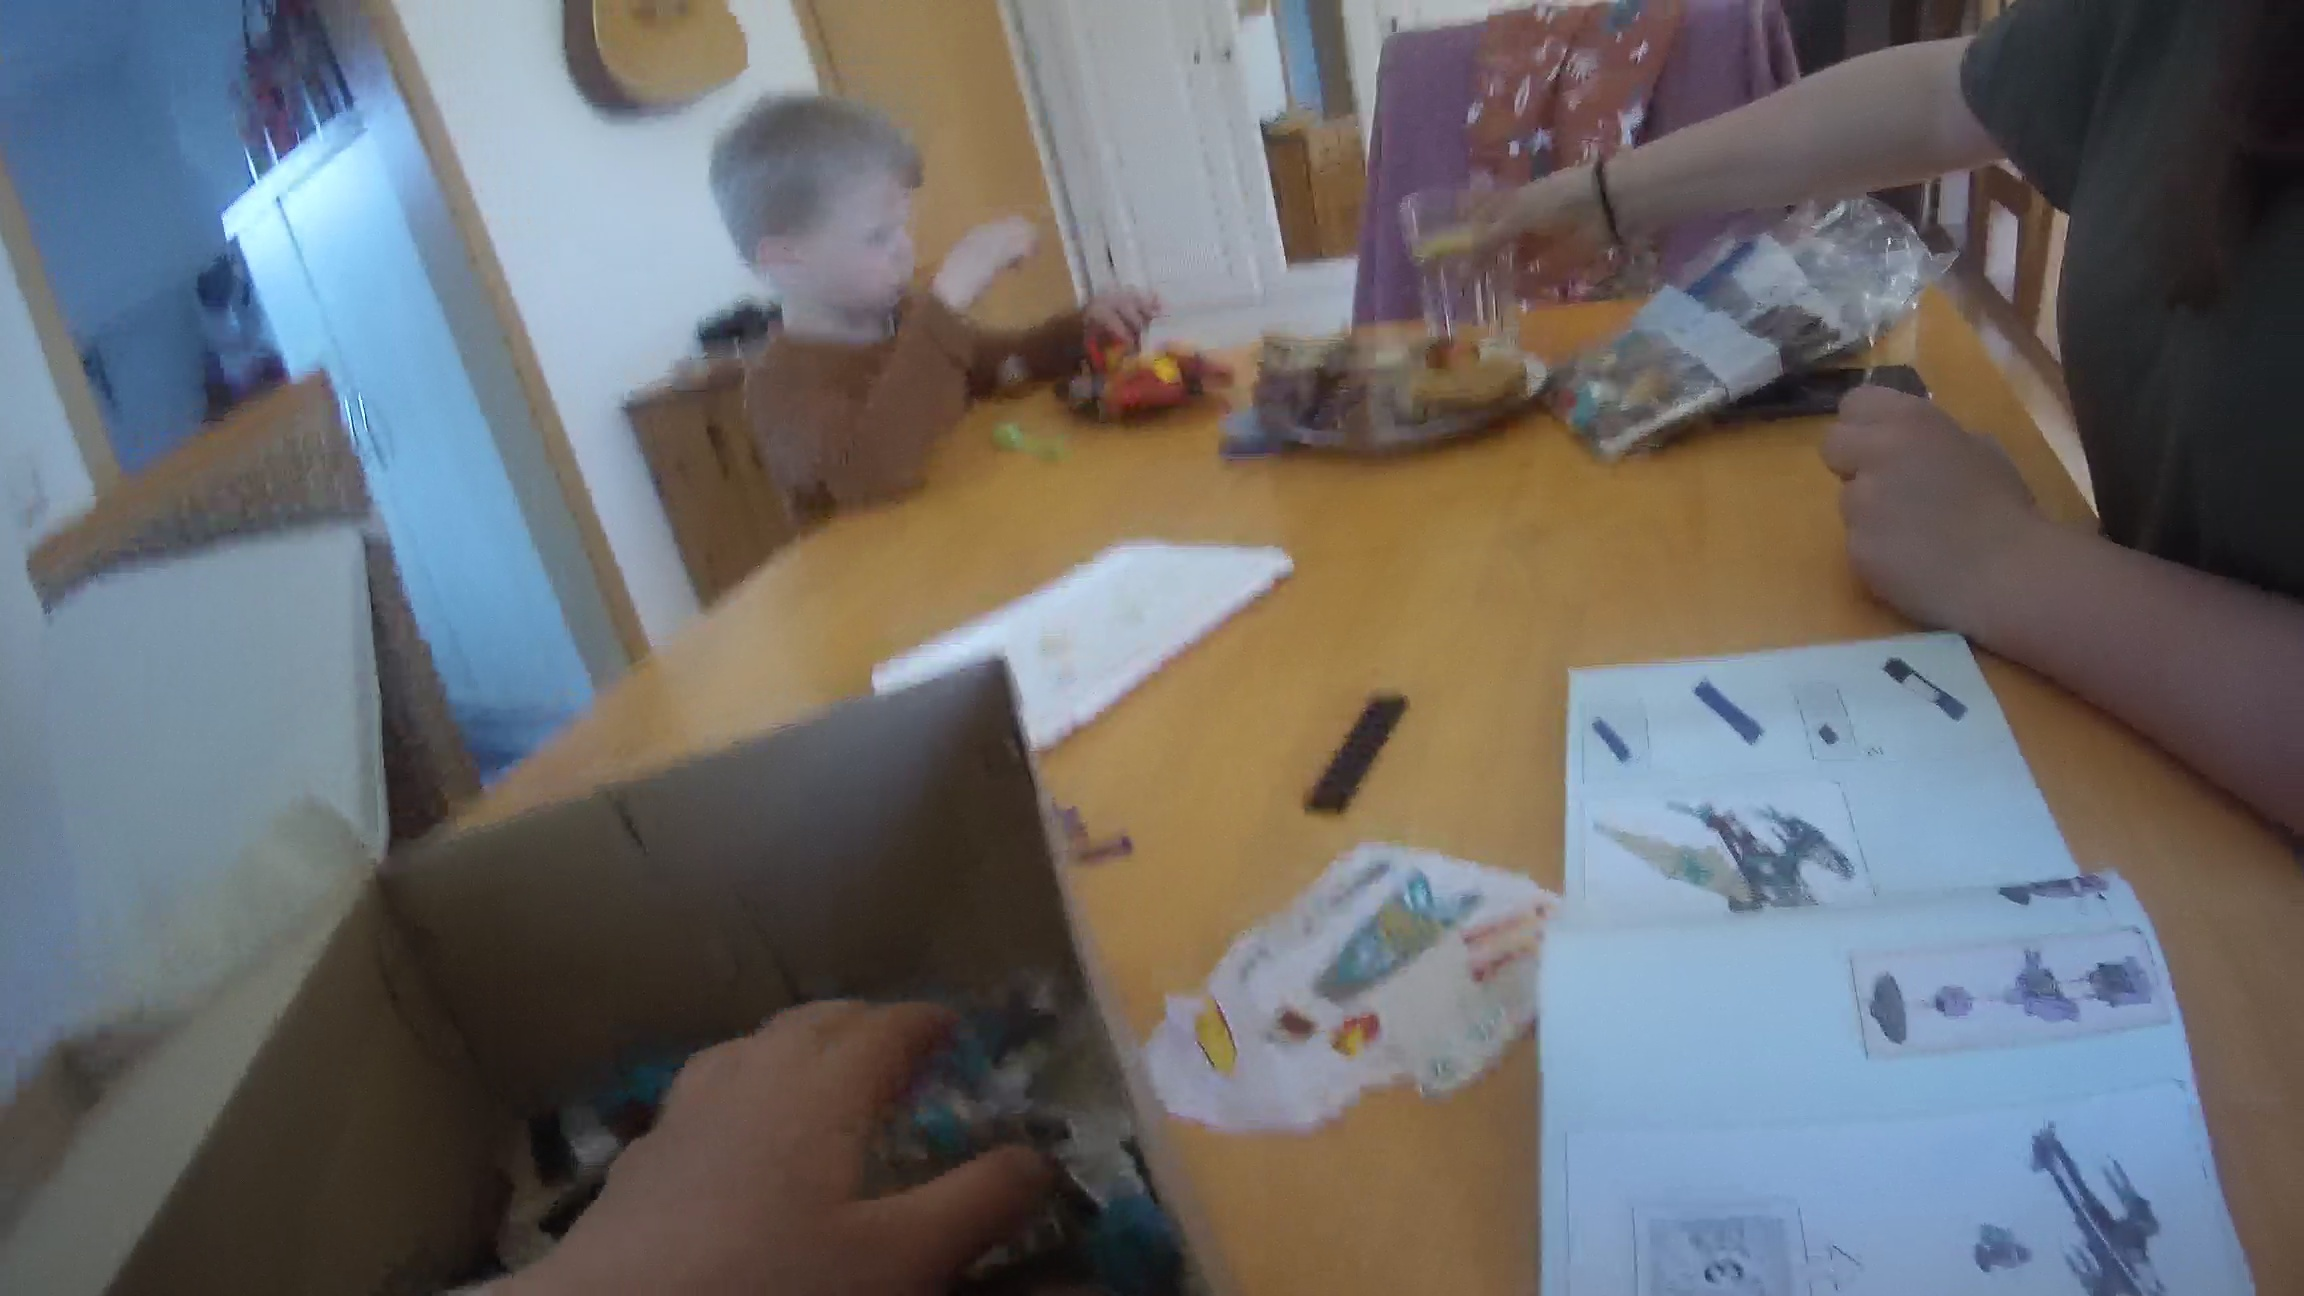

In [19]:
display_mtcnn_detection_results_on_image('quantex_at_home_id255706_2018_12_21_01_031860')


## Run MTCNN Model on Single Frame

In [11]:
def run_mtcnn_on_image(image_name):
    image_path = f'../../../ProcessedData/images/{image_name}.jpg'
    # Create face detector
    mtcnn = MTCNN(keep_all=True, device='cuda')

    # Load the image using OpenCV
    frame = cv2.imread(image_path)
    # Convert the image from BGR (OpenCV default) to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert the NumPy array to a PIL Image
    frame = Image.fromarray(frame)

    # Detect face
    boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    if landmarks:
        for landmark in landmarks:
            left_eye = landmark[0]
            right_eye = landmark[1]
            nose = landmark[2]
            left_mouth_corner = landmark[3] 
            right_mouth_corner = landmark[4]

        # Visualize#
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(frame)
    ax.axis('off')
    if boxes is not None:
        for box, landmark in zip(boxes, landmarks):
            print(box)
            # Draw the bounding box
            width = box[2] - box[0]  # x2 - x1
            height = box[3] - box[1]  # y2 - y1

            # Create a Rectangle patch
            rect = Rectangle((box[0], box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the rectangle to the plot
            ax.add_patch(rect)
            # ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
            ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
    fig.show()

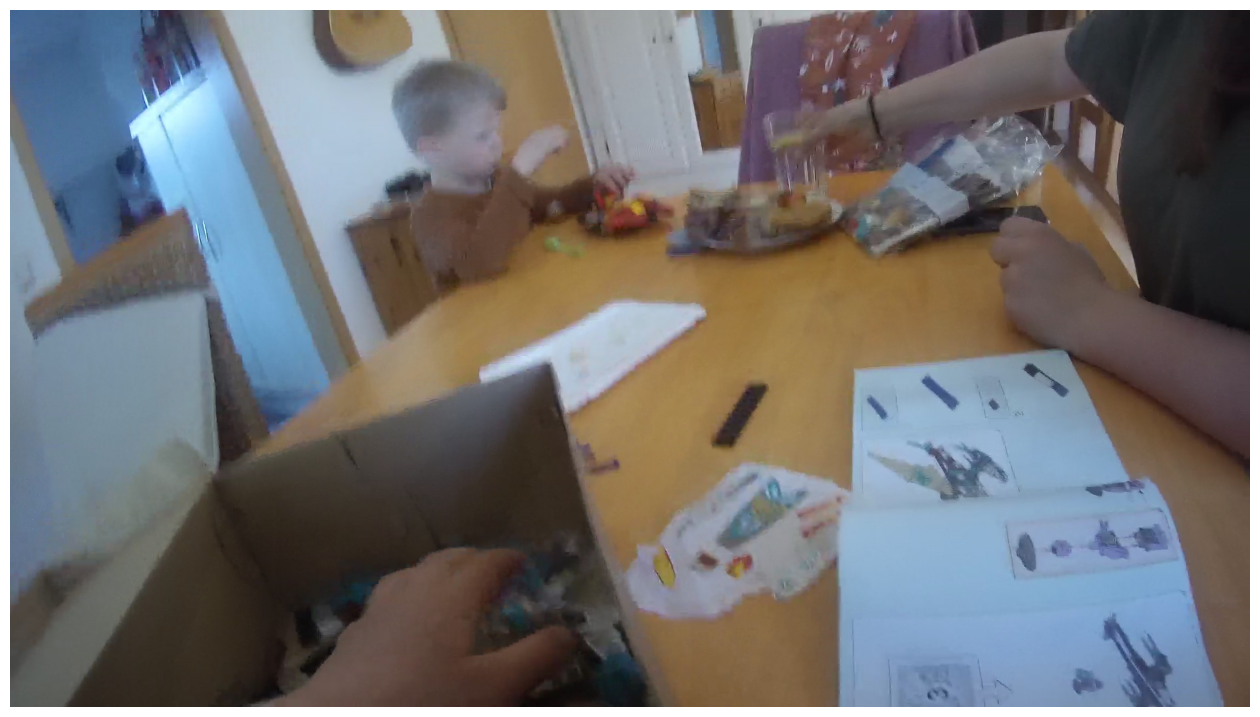

In [20]:
run_mtcnn_on_image('quantex_at_home_id255706_2018_12_21_01_031860')

## Estimate headpose

In [1]:
# Initialize MTCNN for face detection
detector = MTCNN()

def calculate_yaw(landmarks):
    """
    Estimate the yaw (left-right rotation) based on the positions of the eyes.
    """
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    
    # Calculate the angle of the line connecting the eyes
    eye_line = np.array([right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]])
    yaw_angle = np.arctan2(eye_line[1], eye_line[0])  # Yaw angle in radians
    
    return np.degrees(yaw_angle)  # Convert to degrees

def calculate_pitch(landmarks):
    """
    Estimate the pitch (up-down rotation) based on the position of the nose relative to the eyes.
    """
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    nose = landmarks['nose']
    
    # Calculate the center point between the eyes
    eye_center = np.array([(left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2])
    
    # Calculate the vertical distance between the nose and the eye center
    nose_to_eye_center_y = nose[1] - eye_center[1]
    
    # Assuming that if the nose is significantly below the eye center, the head is tilted up, and vice versa
    return nose_to_eye_center_y  # This value can be further scaled or adjusted

def analyze_frame(frame):
    faces = detector.detect_faces(frame)
    for face in faces:
        landmarks = face['keypoints']
        yaw = calculate_yaw(landmarks)
        pitch = calculate_pitch(landmarks)
        
        print(f"Yaw: {yaw:.2f} degrees, Pitch: {pitch:.2f}")

        # Determine if the face is looking at the camera (child wearing the camera)
        # Yaw angle close to 0 indicates the face is oriented directly at the camera
        if abs(yaw) < 15:  # Threshold can be adjusted based on experimental observations
            print("The person is likely looking at the child.")
        else:
            print("The person is likely not looking at the child.")

def get_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame

def get_face_direction_from_image(frame_id):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])

    # Get a specific frame from the video
    frame = get_frame(video_path, frame_number)

    # Analyze the frame for faces and determine if they're looking at the camera
    analyze_frame(frame)

NameError: name 'MTCNN' is not defined